In [1]:
import get_news
import pandas as pd

from pprint import pprint

In [2]:
new_path = './news_20191220.pkl'
#df = get_news.incrental_load('./news_20191220.pkl')

# Incrementally loading data
df = pd.read_pickle(new_path)

In [3]:
df.head()

,timestamp,headline,link,content
0,"Last updated March 06, 2020 20:08:38 AEDT",\n\t\t\tDRASTIC MEASURES: Authorities ask thou...,https://www.news.com.au/lifestyle/health/healt...,Thousands of Queenslanders have locked themsel...
1,"Last updated March 06, 2020 20:08:39 AEDT",\n\t\t\tMum’s ‘accidental’ $3k loo roll stockp...,https://www.news.com.au/lifestyle/real-life/ne...,"Amid the toilet roll panic gripping Australia,..."
2,"Last updated March 06, 2020 20:08:39 AEDT",\n\t\t\tMeghan picture spells trouble for roya...,https://www.news.com.au/entertainment/celebrit...,As Meghan and Harry start their final round of...
3,"Last updated March 06, 2020 20:08:39 AEDT","\n\t\t\tHuge wait for Coles, Woolies deliverie...",https://www.news.com.au/finance/business/retai...,Shoppers who tried to get around the stockpili...
4,"Last updated March 06, 2020 20:08:40 AEDT",\n\t\t\t‘Irresponsible’: Trump’s virus claim b...,https://www.news.com.au/lifestyle/health/healt...,"In an extraordinary interview, Donald Trump re..."


## Stem/Tokenise

Tokenise is basically a function converts sentses into "tokens" or a list of words. In function below we did **stem** on top of the tokenised words, and removed **stop words** from the tokens

In [4]:
import nltk
import re
from nltk.tokenize import punkt
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer 
  
#sample = df.sample(1).content.iloc[0]
keep = re.compile('[a-zA-Z]')

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def stem_tokenise(corpus):    
    return [lemmatizer.lemmatize(ps.stem(w.lower())) for w in word_tokenize(corpus) if re.match(keep, w)]

# stem tokenise the stop words as well
stop_words = stem_tokenise(" ".join(list(set(stopwords.words('english')))))

In [5]:
import spacy

def cleansing(text):    
    # Remove Emails
    text = re.sub('\S*@\S*\s?', '', text) 

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    
    return text

# first of all remove the customerised clearning, then stem tokenise
data = df.content.map(cleansing).map(lambda x: " ". join(stem_tokenise(x)))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
#data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:2])



In [6]:
print(data.to_list()[1])

amid the toilet roll panic grip australia one famili ha the opposit problem with box and box of the stuff pile up in their home the coronaviru outbreak ha left aussi fight for a number of everyday household food and item oop a queensland-bas famili reveal how they accident order box of premium toilet paper by mistak facebook/haide janetzkisourc facebook cash is king the say goe but it seem the new currenc is toilet paper especi a aussi raid supermarket shelv in a desper bid to ensur they have suppli one famili that ha been left with what could have been a valuabl stockpil wa the janetzki a famili of six from toowomba queensland who end up with a whop roll of toilet paper after an onlin order mistak mum haide janetzki told news.com.au the mistak happen after the famili decid to switch product not long after christma i wa previous get recycl toilet paper deliv from the toilet paper compani who give a crap everi week she said but at christma time they were offer a christma gift wrap paper

## SKlearn DTM

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Below is an example of sklearn LDA, the problem is it is pretty slow and not as customisable compared to gensim.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# use own tokeniser and stopwords (note: do the same processing for stop words)
#cv = CountVectorizer(stop_words=stop_words, tokenizer=stem_tokenise)

cv = CountVectorizer(analyzer='word',       
         min_df=10,                        # minimum reqd occurences of a word 
         stop_words='english',             # remove stop words
         lowercase=True,                   # convert all words to lowercase
         token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
         # max_features=50000,             # max number of uniq words
)


# get the dtm (coverting the matrix into dataframe)
data_cv = cv.fit_transform(data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index
#pprint(data_dtm)

# calculate the sparsity
data_dense = data_cv.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  26.815715929639982 %


In [8]:
import numpy as np
data_dtm.iloc[1]
#pprint(row.nlargest(10))
#pprint(data.iloc[300])

aap        0
abl        0
accept     0
accord     0
account    0
          ..
wrong      0
wrote      0
year       2
york       0
young      0
Name: 1, Length: 395, dtype: int64

## SKlearn Latent Direchlet Allocation

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [9]:
# simple LDA
lda = LatentDirichletAllocation(n_components=10, max_iter = 10, learning_method = 'online', batch_size = 128, random_state=0)
lda_output = lda.fit_transform(data_cv)

In [10]:
print("log likelihood: ", lda.score(data_cv))
print("Perplexity: ", lda.perplexity(data_cv))
pprint(lda.get_params())

log likelihood:  -88306.81611103109
Perplexity:  343.5179311852752
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Perform a grid search

In [11]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_cv)

#best model
best_model = model.best_estimator_

In [12]:
print("best model parameters: ", best_model.get_params())
result = pd.DataFrame(model.cv_results_)
result

best model parameters:  {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.9, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.341208,0.035660,0.010394,0.001622,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-23302.908624,-23258.311493,-26114.182780,-21720.110304,-14042.708907,-21687.644422,4077.165888,3
1,0.350398,0.043356,0.012200,0.001939,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-25716.778844,-24633.884984,-28673.253386,-24024.489905,-16304.249171,-23870.531258,4106.818885,5
2,0.366001,0.032359,0.013603,0.001746,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-27071.489151,-26674.707999,-29989.567921,-25927.465044,-18885.293889,-25709.704801,3680.296726,7
3,0.349198,0.016216,0.012204,0.004125,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-23283.496021,-23185.040659,-26215.673122,-21741.603366,-13750.583339,-21635.279301,4201.859622,2
4,0.341600,0.021939,0.011600,0.001744,0.7,20,"{'learning_decay': 0.7, 'n_components': 20}",-24862.362618,-25071.958122,-28430.973775,-23756.855015,-16248.272026,-23674.084311,4028.488376,4
5,0.341191,0.013218,0.014008,0.002830,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-27703.646977,-27328.400777,-30605.067983,-26727.840232,-18724.891153,-26217.969424,3977.263370,9
6,0.343401,0.023847,0.010595,0.001020,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-23262.845064,-22897.099734,-25632.431455,-21609.926456,-14034.027396,-21487.266021,3946.860020,1
7,0.317601,0.014504,0.012199,0.000981,0.9,20,"{'learning_decay': 0.9, 'n_components': 20}",-25603.496418,-25681.767014,-28598.022280,-24094.019105,-17088.388281,-24213.138620,3849.504533,6
8,0.338003,0.016938,0.013799,0.000758,0.9,30,"{'learning_decay': 0.9, 'n_components': 30}",-27762.839553,-27286.309242,-30341.519504,-25519.847588,-19166.947206,-26015.492619,3755.820632,8


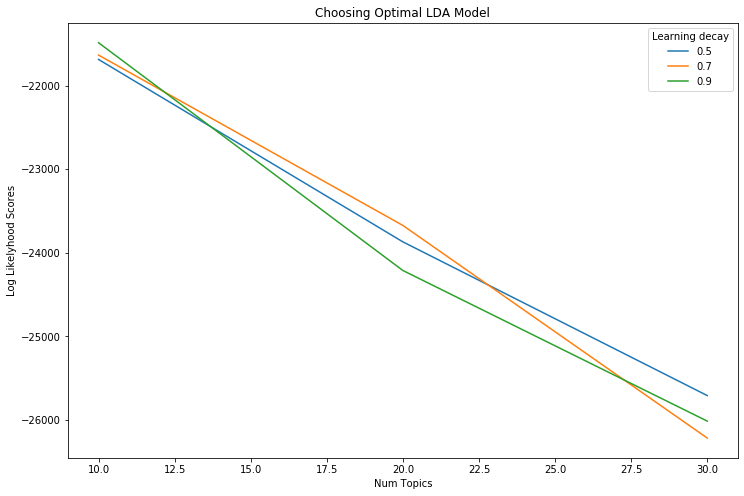

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
for x in result.param_learning_decay.unique():
    plt.plot(result[result.param_learning_decay==x].param_n_components, result[result.param_learning_decay==x].mean_test_score, label=x)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Finding Dominate Topic

In [14]:
# Create Document - Topic Matrix
lda_output = best_model.transform(data_cv)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390000,0.610000,0.000000,8
Doc1,0.000000,0.250000,0.000000,0.000000,0.570000,0.170000,0.000000,0.000000,0.000000,0.000000,4
Doc2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5
Doc3,0.000000,0.140000,0.000000,0.000000,0.210000,0.530000,0.000000,0.000000,0.080000,0.050000,5
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.390000,0.000000,0.000000,0.610000,0.000000,8
Doc5,0.000000,0.090000,0.000000,0.000000,0.000000,0.680000,0.000000,0.000000,0.220000,0.000000,5
Doc6,0.000000,0.000000,0.080000,0.000000,0.000000,0.820000,0.000000,0.000000,0.100000,0.000000,5
Doc7,0.000000,0.240000,0.000000,0.000000,0.120000,0.640000,0.000000,0.000000,0.000000,0.000000,5
Doc8,0.120000,0.300000,0.000000,0.000000,0.000000,0.570000,0.000000,0.000000,0.000000,0.000000,5
Doc9,0.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760000,9


## Review Topics Distribution

In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,22
1,1,12
2,0,10
3,8,9
4,3,9
5,9,6
6,4,4
7,6,2
8,2,2
9,7,1


## Visualize the LDA model with pyLDAvis

In [16]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_model, data_cv, cv, mds='tsne')

pyLDAvis.display(panel)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
topics = np.argmax(best_model.transform(data_cv), axis=1)

In [ ]:
topics